In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

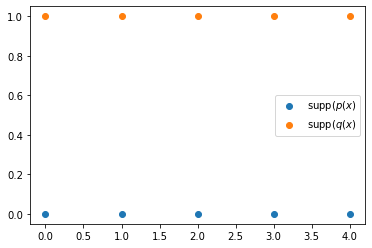

In [2]:
n_points = 5
a = np.array([[i, 0] for i in range(n_points)])
b = np.array([[i, 1] for i in range(n_points)])

plt.figure()
plt.scatter(a[:, 0], a[:, 1], label='supp($p(x)$')
plt.scatter(b[:, 0], b[:, 1], label='supp($q(x)$')
plt.legend()

In [3]:
x = torch.tensor(a, dtype=torch.float)
y = torch.tensor(b, dtype=torch.float)

In [4]:
# Cost Matrix
p = 2
x_col = x.unsqueeze(1)
y_lin = y.unsqueeze(0)
c = torch.sum((torch.abs(x_col - y_lin)) ** 2, 2)

In [5]:
c

tensor([[ 1.,  2.,  5., 10., 17.],
        [ 2.,  1.,  2.,  5., 10.],
        [ 5.,  2.,  1.,  2.,  5.],
        [10.,  5.,  2.,  1.,  2.],
        [17., 10.,  5.,  2.,  1.]])

In [6]:
# Sinkhorn's Algorithm
mu = torch.ones(n_points,requires_grad=True) / n_points
nu = torch.ones(n_points,requires_grad=True) / n_points
epsilon = 1
K = torch.exp(-c/epsilon)

v = torch.ones(n_points)
max_niter = 100
actual_niter = 0
threshold = 1e-3
for _ in range(max_niter):
    v1 = v
    u = mu / torch.matmul(K, v)
    v = nu / torch.matmul(K.T, u)
    
    err = torch.sum(torch.abs(v-v1))
    actual_niter += 1
    if err < threshold:
        break

In [7]:
actual_niter

8

In [8]:
u

tensor([0.3725, 0.3182, 0.3232, 0.3182, 0.3725], grad_fn=<DivBackward0>)

In [9]:
v

tensor([1.0971, 0.9374, 0.9523, 0.9374, 1.0971], grad_fn=<DivBackward0>)

In [10]:
P = torch.matmul(torch.matmul(torch.diag(u), K), torch.diag(v))
P

tensor([[1.5035e-01, 4.7257e-02, 2.3901e-03, 1.5853e-05, 1.6920e-08],
        [4.7244e-02, 1.0972e-01, 4.1005e-02, 2.0096e-03, 1.5848e-05],
        [2.3890e-03, 4.0997e-02, 1.1321e-01, 4.0997e-02, 2.3890e-03],
        [1.5848e-05, 2.0096e-03, 4.1005e-02, 1.0972e-01, 4.7244e-02],
        [1.6920e-08, 1.5853e-05, 2.3901e-03, 4.7257e-02, 1.5035e-01]],
       grad_fn=<MmBackward>)

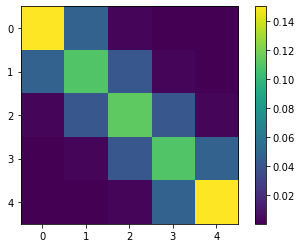

In [11]:
plt.figure()
plt.imshow(P.detach().numpy())
plt.colorbar()

In [12]:
dist = torch.sum(P * c)
dist

tensor(1.4079, grad_fn=<SumBackward0>)

In [92]:
# Example 2
def u(x):
    if x > np.pi/2:
        return 0
    elif x < -np.pi/2:
        return 0
    else:
        return np.cos(x)
t = np.linspace(-5*np.pi/2, 5*np.pi/2, 100)
a = np.array(list(map(u, t)))

In [93]:
def shift(u, s):
    n = len(u)
    assert np.abs(s) < n
    if s > 0:
        return np.concatenate((np.full(s, 0), u[:-s]))
    elif s < 0:
        return np.concatenate((u[-s:], np.full(-s, 0)))
    else:
        return u

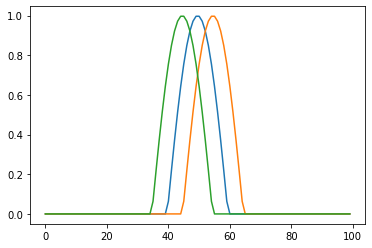

In [94]:
plt.figure()
plt.plot(a)
plt.plot(shift(a, 5))
plt.plot(shift(a, -5))

In [95]:
s = np.arange(-20, 20, 2)
ns = len(s)
A = np.matmul(a.reshape(-1, 1), np.ones((1, ns)))
B = np.zeros((len(a), ns))
for i, st in enumerate(s):
    B[:, i] = shift(a, st)

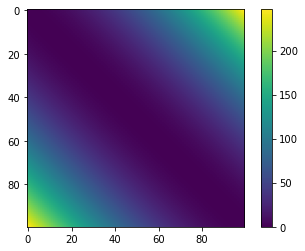

In [96]:
t_col = np.expand_dims(t, 0)
t_lin = np.expand_dims(t, 1)
cost = (t_lin - t_col) ** 2
plt.figure()
plt.imshow(cost)
plt.colorbar()

In [108]:
eps = 1
K = np.exp(-cost/eps)

In [109]:
K.shape

(100, 100)

In [110]:
# Sinkhorn's Algorithm
V = np.ones((len(a), ns))
max_niter = 100
actual_niter = 0
threshold = 1e-3
for _ in range(max_niter):
    V1 = V
    U = A / np.matmul(K, V)
    V = B / np.matmul(K.T, U)
    
    err = np.sum(np.abs(V-V1))
    actual_niter += 1
    if err < threshold:
        break

In [111]:
actual_niter

26

In [119]:
U.shape

(100, 20)

In [120]:
a0 = np.array([1, 2])
a1 = np.arange(4).reshape(2, 2)
a2 = np.array([2, 3])

In [121]:
a0, a1, a2

(array([1, 2]),
 array([[0, 1],
        [2, 3]]),
 array([2, 3]))

In [123]:
a0.reshape(-1, 1) * a1

array([[0, 1],
       [4, 6]])

In [126]:
a1 * a2.reshape(1, -1)

array([[0, 3],
       [4, 9]])

In [127]:
P = np.expand_dims(U.T, 2) * K * np.expand_dims(V.T, 1)

In [128]:
P.shape

(20, 100, 100)

In [131]:
e = np.matmul(np.matmul(np.diag(U[:, 0]), K), np.diag(V[:, 0])) - P[0]

In [133]:
np.abs(e).max()

0.0

In [138]:
D = np.sum(P * cost, axis=(1, 2))

In [139]:
D.shape

(20,)

In [140]:
D

array([131.68396649, 107.54441184,  85.94586294,  66.8883198 ,
        50.3717824 ,  36.39625076,  24.96172487,  16.06820474,
         9.71569036,   5.90418173,   4.63367885,   5.90418173,
         9.71569036,  16.06820474,  24.96172487,  36.39625076,
        50.3717824 ,  66.8883198 ,  85.94586294, 107.54441184])

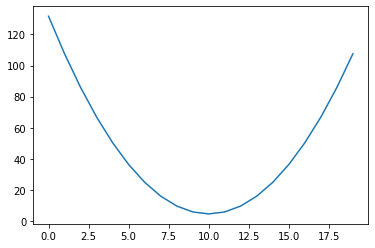

In [141]:
plt.figure()
plt.plot(D)
plt.show()

In [142]:
D2 = np.sum((A - B) ** 2, axis=0)

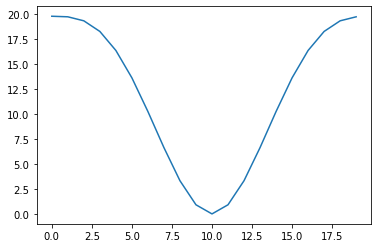

In [144]:
plt.figure()
plt.plot(D2)